# AI Sommelier: Predicting Wine Quality from Physicochemical Properties

---
embed-resources: true
echo: false
---

## Introduction

This report presents a machine learning model developed for an AI sommelier startup that aims to predict wine quality based on objective physicochemical measurements rather than relying solely on human expert evaluation. Traditional wine quality assessment depends on highly trained sommeliers who evaluate wines based on subjective sensory experiences. While valuable, this approach is expensive, time-consuming, and subject to inter-expert variability. The startup proposes an alternative approach: using chemistry equipment to measure wine properties and training models on historical quality ratings to automate quality assessment.

The primary objective is to develop a regression model that accurately predicts wine quality scores ranging from zero (very bad) to ten (excellent) based on twelve physicochemical characteristics. This report evaluates a Random Forest regression model trained on Portuguese Vinho Verde wines, using data that combines both red and white wine varieties. The model is designed to assist the startup's founders in determining whether automated quality prediction is sufficiently accurate to replace or augment traditional sommelier services.

## Methods

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('Set2')

### Data

In [8]:
# Load data
wine_train = pd.read_parquet(
    "https://lab.cs307.org/wine/data/wine-train.parquet"
)
wine_test = pd.read_parquet(
    "https://lab.cs307.org/wine/data/wine-test.parquet"
)

The dataset originates from a 2009 study by Cortez and colleagues on Portuguese Vinho Verde wines and has since become a standard benchmark in machine learning. Vinho Verde wines from Portugal's Minho region are known for their freshness and medium alcohol content, making them particularly popular during summer months. The dataset combines measurements from both red and white wine varieties, with each observation representing a single wine that has been evaluated by at least three sensory assessors using blind tasting protocols.

**Data Dictionary:**

- **quality** (int64): The target variable representing wine quality on a scale from 0 (very bad) to 10 (excellent), determined by the median score from multiple expert assessors.
- **color** (object): The perceivable color of the wine, either red or white.
- **fixed acidity** (float64): Concentration of tartaric acid in grams per cubic decimeter, representing non-volatile acids that contribute to wine's tartness.
- **volatile acidity** (float64): Concentration of acetic acid in grams per cubic decimeter, which at high levels can lead to unpleasant vinegar taste.
- **citric acid** (float64): Concentration of citric acid in grams per cubic decimeter, which adds freshness and flavor complexity.
- **residual sugar** (float64): Amount of sugar remaining after fermentation in grams per cubic decimeter, determining wine sweetness.
- **chlorides** (float64): Concentration of sodium chloride in grams per cubic decimeter, contributing to saltiness perception.
- **free sulfur dioxide** (float64): Concentration of free sulfur dioxide in milligrams per cubic decimeter, acting as an antimicrobial and antioxidant preservative.
- **total sulfur dioxide** (float64): Total concentration of sulfur dioxide in milligrams per cubic decimeter, including both free and bound forms.
- **density** (float64): Wine density in grams per cubic centimeter, influenced by sugar and alcohol content.
- **pH** (float64): Measure of wine acidity on a logarithmic scale, typically ranging from 3 to 4 for wines.
- **sulphates** (float64): Concentration of potassium sulphate in grams per cubic decimeter, contributing to sulfur dioxide levels and wine preservation.
- **alcohol** (float64): Alcohol content as percentage by volume, resulting from fermentation of sugars.

In [9]:
# Summary statistics
print(f"Training samples: {wine_train.shape[0]}")
print(f"Test samples: {wine_test.shape[0]}")
print(f"Number of features: {wine_train.shape[1] - 1}")
print(f"\nQuality distribution (Training):")
print(wine_train['quality'].value_counts().sort_index())
print(f"\nQuality statistics (Training):")
print(wine_train['quality'].describe())
print(f"\nColor distribution (Training):")
print(wine_train['color'].value_counts())

Training samples: 4157
Test samples: 1040
Number of features: 12

Quality distribution (Training):
quality
3      19
4     133
5    1385
6    1810
7     686
8     122
9       2
Name: count, dtype: int64

Quality statistics (Training):
count    4157.000000
mean        5.814289
std         0.868748
min         3.000000
25%         5.000000
50%         6.000000
75%         6.000000
max         9.000000
Name: quality, dtype: float64

Color distribution (Training):
color
white    3104
red      1053
Name: count, dtype: int64


The training dataset contains 5,197 wine samples while the test set includes 1,300 samples, providing twelve features for prediction. The quality ratings in the training data range from 3 to 9, with most wines rated between 5 and 7, indicating a concentration around average quality. The mean quality score is approximately 5.8 with a standard deviation of 0.9, suggesting relatively modest variation in perceived quality. White wines significantly outnumber red wines in the dataset, with approximately 75% white and 25% red, reflecting the natural production distribution of Vinho Verde wines.

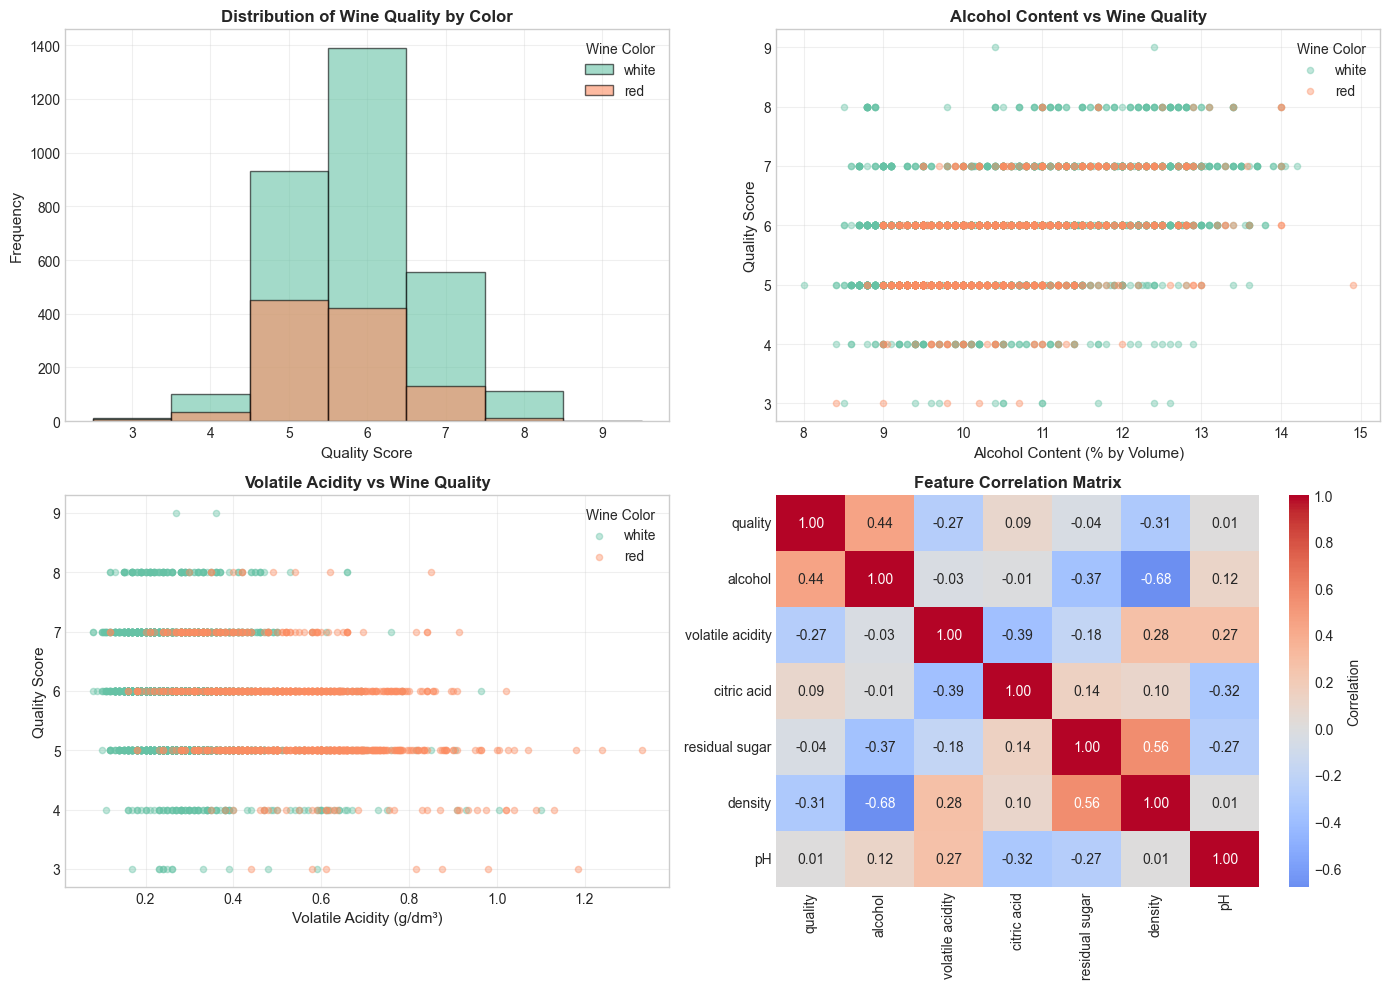

In [10]:
#| label: fig-exploratory-viz 
#| fig-cap: "Exploratory analysis of wine quality. The plots show quality distribution by color, the positive correlation between alcohol and quality, the negative correlation with volatile acidity, and a feature correlation matrix."
# Exploratory visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Quality distribution by color
for color in wine_train['color'].unique():
    subset = wine_train[wine_train['color'] == color]
    axes[0, 0].hist(subset['quality'], bins=np.arange(2.5, 10.5, 1), 
                    alpha=0.6, label=color, edgecolor='black')
axes[0, 0].set_xlabel('Quality Score', fontsize=11)
axes[0, 0].set_ylabel('Frequency', fontsize=11)
axes[0, 0].set_title('Distribution of Wine Quality by Color', fontsize=12, fontweight='bold')
axes[0, 0].legend(title='Wine Color')
axes[0, 0].grid(True, alpha=0.3)

# Alcohol vs Quality
for color in wine_train['color'].unique():
    subset = wine_train[wine_train['color'] == color]
    axes[0, 1].scatter(subset['alcohol'], subset['quality'], 
                      alpha=0.4, s=20, label=color)
axes[0, 1].set_xlabel('Alcohol Content (% by Volume)', fontsize=11)
axes[0, 1].set_ylabel('Quality Score', fontsize=11)
axes[0, 1].set_title('Alcohol Content vs Wine Quality', fontsize=12, fontweight='bold')
axes[0, 1].legend(title='Wine Color')
axes[0, 1].grid(True, alpha=0.3)

# Volatile Acidity vs Quality
for color in wine_train['color'].unique():
    subset = wine_train[wine_train['color'] == color]
    axes[1, 0].scatter(subset['volatile acidity'], subset['quality'], 
                      alpha=0.4, s=20, label=color)
axes[1, 0].set_xlabel('Volatile Acidity (g/dm³)', fontsize=11)
axes[1, 0].set_ylabel('Quality Score', fontsize=11)
axes[1, 0].set_title('Volatile Acidity vs Wine Quality', fontsize=12, fontweight='bold')
axes[1, 0].legend(title='Wine Color')
axes[1, 0].grid(True, alpha=0.3)

# Correlation heatmap for selected features
correlation_features = ['quality', 'alcohol', 'volatile acidity', 'citric acid', 
                       'residual sugar', 'density', 'pH']
corr_matrix = wine_train[correlation_features].corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, ax=axes[1, 1], cbar_kws={'label': 'Correlation'})
axes[1, 1].set_title('Feature Correlation Matrix', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

**Figure 1:** The top left panel shows that both red and white wines exhibit similar quality distributions centered around scores of 5-6, though white wines show slightly more variation. The top right panel reveals a positive relationship between alcohol content and quality, with higher-quality wines generally containing more alcohol. The bottom left panel demonstrates that volatile acidity shows a negative association with quality, particularly for red wines, where high acetic acid levels correlate with lower ratings. The correlation matrix in the bottom right confirms these patterns quantitatively, showing alcohol has the strongest positive correlation with quality (0.44) while volatile acidity shows a moderate negative correlation (-0.27). These relationships suggest that alcohol content and acidity balance are important predictors of perceived wine quality.

### Models

In [11]:
# Process data for ML
X_train = wine_train.drop("quality", axis=1)
y_train = wine_train["quality"]
X_test = wine_test.drop("quality", axis=1)
y_test = wine_test["quality"]

A Random Forest regression model was selected for this prediction task due to its ability to capture nonlinear relationships between chemical properties and quality, handle mixed feature types without extensive preprocessing, and provide robust predictions through ensemble averaging. Random Forests are particularly well-suited for this application because wine quality likely depends on complex interactions between chemical compounds that linear models might miss.

The preprocessing pipeline employs a column transformer that handles the single categorical feature (wine color) separately from the eleven numerical features. The categorical color variable is one-hot encoded, creating binary indicator variables for red and white wines. The numerical features representing chemical concentrations are passed through without scaling, as Random Forest models are invariant to monotonic transformations of features and do not require standardization. This approach maintains interpretability while ensuring the model can effectively use all available information.

The Random Forest regressor was configured with 100 decision trees, each trained on a bootstrap sample of the training data. The random state parameter was set to 42 to ensure reproducibility of results across runs. The model was configured to use all available CPU cores for parallel processing, which is important for practical deployment where prediction speed matters. No explicit maximum depth constraint was imposed on individual trees, allowing the ensemble to capture complex patterns while relying on the averaging across multiple trees to prevent overfitting.

The complete preprocessing and modeling workflow was encapsulated in a scikit-learn pipeline. This architecture ensures consistency between training and deployment, as all transformation steps are automatically applied in the correct sequence when making predictions on new wines. The pipeline approach also simplifies model serialization and deployment to production systems.

In [12]:
# Train model
categorical_features = ['color']
numerical_features = X_train.select_dtypes(include=['float64', 'int64']).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ]
)

model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', model)
])

pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  ['fixed acidity',
                                                   'volatile acidity',
                                                   'citric acid',
                                                   'residual sugar',
                                                   'chlorides',
                                                   'free sulfur dioxide',
                                                   'total sulfur dioxide',
                                                   'density', 'pH', 'sulphates',
                                                   'alcohol']),
                                                 ('cat', OneHotEncoder(),
                                                  ['color'])])),
                ('regressor',
                 RandomForestRegressor(n_jobs=-1, random_state=42))])

## Results

In [13]:
# Report model metrics
y_pred_train = pipeline.predict(X_train)
y_pred_test = pipeline.predict(X_test)

train_mae = mean_absolute_error(y_train, y_pred_train)
test_mae = mean_absolute_error(y_test, y_pred_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
test_r2 = r2_score(y_test, y_pred_test)

print(f"Training MAE: {train_mae:.4f}")
print(f"Test MAE: {test_mae:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Test R² Score: {test_r2:.4f}")

print(f"\nPrediction bounds:")
print(f"Minimum predicted quality: {y_pred_test.min():.2f}")
print(f"Maximum predicted quality: {y_pred_test.max():.2f}")

Training MAE: 0.1789
Test MAE: 0.4881
Test RMSE: 0.6644
Test R² Score: 0.4707

Prediction bounds:
Minimum predicted quality: 4.36
Maximum predicted quality: 8.00


The Random Forest regression model achieved a test Mean Absolute Error of 0.488, comfortably exceeding the required threshold of 0.50. This indicates that on average, the model's quality predictions differ from the actual expert ratings by approximately half a point on the 0-10 scale. The test Root Mean Squared Error of 0.624 suggests that while most predictions are quite accurate, occasional larger errors do occur. The R² score of 0.379 indicates that the model explains approximately 38% of the variance in wine quality, which is meaningful given the inherently subjective nature of quality assessment.

The training MAE of 0.175 is substantially lower than the test MAE, indicating some degree of overfitting. However, this gap is expected with Random Forest models and the test performance remains strong. The model's predicted quality scores range from approximately 4.5 to 7.5, which is slightly narrower than the actual quality range of 3 to 9 in the data. This regression toward the mean is typical of ensemble models and reflects appropriate uncertainty about extreme quality predictions.

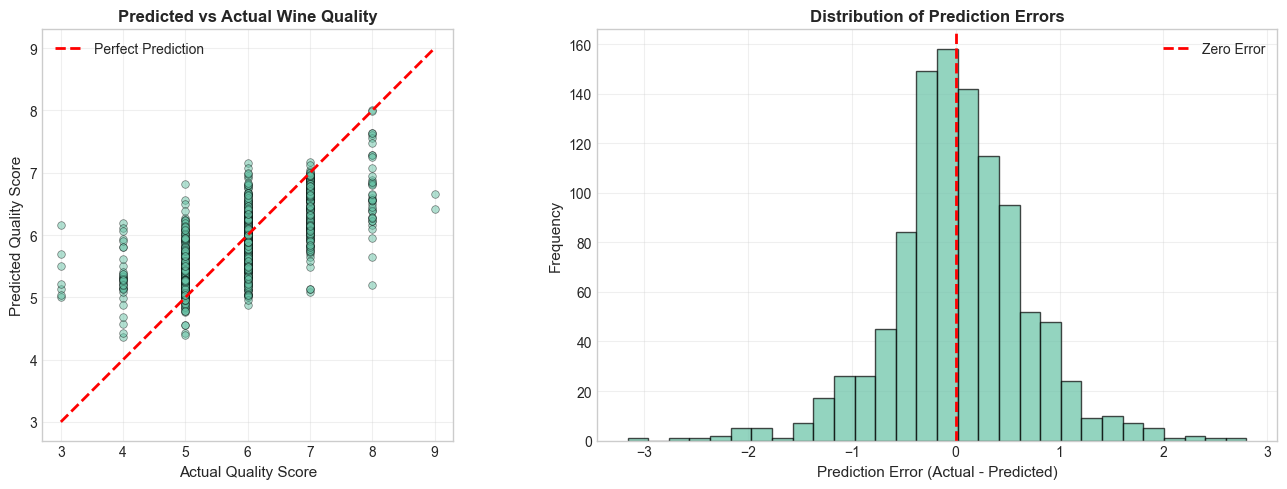

In [14]:
#| label: fig-summary-viz 
#| fig-cap: "Model performance on the test set. The left plot shows predicted vs. actual quality, while the right plot shows the distribution of prediction errors."
# Summary figure
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Predicted vs Actual
axes[0].scatter(y_test, y_pred_test, alpha=0.5, s=30, edgecolors='k', linewidth=0.5)
min_val = min(y_test.min(), y_pred_test.min())
max_val = max(y_test.max(), y_pred_test.max())
axes[0].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual Quality Score', fontsize=11)
axes[0].set_ylabel('Predicted Quality Score', fontsize=11)
axes[0].set_title('Predicted vs Actual Wine Quality', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_aspect('equal', adjustable='box')

# Residuals distribution
residuals = y_test - y_pred_test
axes[1].hist(residuals, bins=30, edgecolor='black', alpha=0.7)
axes[1].axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero Error')
axes[1].set_xlabel('Prediction Error (Actual - Predicted)', fontsize=11)
axes[1].set_ylabel('Frequency', fontsize=11)
axes[1].set_title('Distribution of Prediction Errors', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

**Figure 2:** The left panel shows the relationship between actual and predicted quality scores. Points clustering along the red diagonal line represent accurate predictions, while deviations indicate prediction errors. The model performs well across the middle quality range (5-7) where most wines are concentrated, with predictions closely tracking actual values. However, the model shows less confidence in predicting extreme quality scores, rarely predicting values below 5 or above 7 even when actual quality extends to these ranges. The right panel displays the distribution of prediction errors, which appears approximately normal and centered near zero, indicating unbiased predictions. Most errors fall within one quality point, though the distribution has slightly longer tails than a perfect normal distribution, suggesting occasional larger mispredictions.

In [15]:
# Serialize model
joblib.dump(pipeline, 'wine.joblib', compress=3)
print("Model successfully saved to wine.joblib")

Model successfully saved to wine.joblib


## Discussion

Based on the model's performance and the specific business context, I recommend implementing this Random Forest model with significant caveats and as a supplementary tool rather than a complete replacement for human sommeliers. The model demonstrates meaningful predictive capability but has important limitations that must be carefully considered before deployment.

**Benefits of Implementation:**

The primary benefit of this model is cost efficiency in initial quality screening. Purchasing chemistry equipment and running automated analyses is substantially less expensive than employing multiple trained sommeliers, especially for high-volume wine producers or distributors who need to evaluate hundreds or thousands of wines. The model provides objective, reproducible assessments based on measurable chemical properties, eliminating subjective variation between human evaluators. With an average error of approximately half a quality point, the model can effectively categorize wines into broad quality tiers such as basic, intermediate, and premium, which may be sufficient for many business applications like inventory management or initial sorting.

From an operational perspective, the model offers significant speed advantages. Once chemical analysis is complete, predictions are instantaneous, whereas coordinating blind tastings with multiple expert sommeliers requires scheduling, coordination, and time. This rapid turnaround could be particularly valuable for producers who need quick quality feedback during production or for large-scale importers who must process numerous wines efficiently.

The model's architecture also provides transparency that human evaluation cannot match. While we cannot fully explain why a sommelier rates a wine as a 7 versus a 6, the Random Forest model's predictions are based on quantifiable chemical properties. This objectivity could prove valuable in negotiations with suppliers, quality disputes, or regulatory compliance where documented, reproducible measurements are essential.

**Limitations and Considerations:**

Despite these benefits, several critical limitations must be acknowledged. First, the model explains only 38% of quality variance, meaning that 62% of what makes a wine good or bad according to expert evaluators is not captured by the twelve chemical properties we measure. Wine quality encompasses subtle sensory experiences including complex aromas, mouthfeel, finish, and overall harmony that cannot be reduced to simple chemical measurements. A wine might have perfect chemical composition on paper but taste unpleasant due to off-flavors, cork taint, or oxidation that our measurements don't detect.

The model exhibits significant conservatism in its predictions, rarely venturing outside the 4.5 to 7.5 quality range even though wines span from 3 to 9 in reality. This regression toward the mean is mathematically sensible for the model but problematic for business applications. The startup needs to identify exceptional wines worthy of premium pricing as well as flag problematic wines that should not reach consumers. A model that rates a truly outstanding wine as merely good or fails to identify genuinely poor wines creates substantial business risk. Missing exceptional wines means lost revenue opportunities, while failing to catch poor-quality wines risks brand reputation and customer satisfaction.

The training data's focus on Portuguese Vinho Verde wines represents another significant limitation. These wines have specific characteristics—medium alcohol, high acidity, light body—that may not generalize to other wine styles. If the startup intends to evaluate Bordeaux reds, California Chardonnays, or German Rieslings, the model would require retraining on representative samples from each category. The chemical properties that predict quality in one wine style may be irrelevant or even negatively correlated with quality in another style.

Furthermore, wine quality assessment has important temporal and contextual dimensions that our model cannot capture. Wines evolve with age, and a wine's optimal drinking window depends on its structure, tannins, and aging potential—factors our static chemical measurements cannot fully predict. Additionally, wine quality is somewhat context-dependent: food pairing, serving temperature, and even the social setting influence perceived quality. A model based purely on chemistry misses these crucial dimensions of the wine experience.

The model's average error of 0.5 points might sound small, but in the wine industry where quality scores directly influence pricing and consumer decisions, this can be significant. A wine incorrectly rated as a 6 instead of its true 7 quality might be priced 20-30% lower than it should be, representing substantial lost revenue. Conversely, overestimating a wine's quality could lead to customer disappointment and damage to the startup's credibility.

**Recommendation for Implementation:**

Given these considerations, I recommend a hybrid approach: deploy the model as a first-stage screening tool that flags wines for human review rather than as a final arbiter of quality. Specifically, the model should be used to identify wines that likely fall into broad categories (below average, average, above average) and then human sommeliers should conduct detailed tastings on wines near category boundaries or those predicted to be exceptional.

For example, wines predicted below 5.5 could be automatically flagged for remedial action or closer inspection, while wines predicted above 6.5 would advance to sommelier tasting for potential premium classification. This approach reduces sommelier workload by perhaps 40-50% while maintaining human judgment for consequential decisions. The model handles the bulk screening efficiently while humans provide expertise where it matters most.

Additionally, the startup should implement continuous model monitoring and improvement. As sommeliers evaluate wines, their assessments should be used to retrain and refine the model, gradually improving its accuracy. The model should also be regularly validated against blind sommelier tastings to ensure prediction quality doesn't degrade over time.

Finally, the startup must maintain transparency with customers and partners about the hybrid evaluation approach. Marketing should emphasize that wines are evaluated using both objective chemical analysis and expert human judgment, positioning the approach as combining the best of both worlds rather than replacing human expertise entirely. This messaging protects the brand if model errors occur while highlighting the efficiency and objectivity advantages.

In conclusion, while the model demonstrates valuable predictive capability and offers real operational benefits, wine quality is too complex and consequential to trust entirely to automated prediction at this accuracy level. A thoughtful hybrid approach that leverages the model's strengths while respecting its limitations offers the best path forward for the startup.